# Preprocessing

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, recall_score, precision_score, confusion_matrix, f1_score

import xgboost as xgb
from xgboost import XGBClassifier

Load dataset

In [2]:
data = pd.read_csv("D:\IEEE - AI\Competition\diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
data.shape

(768, 9)

In [4]:
print(data.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Visualize data

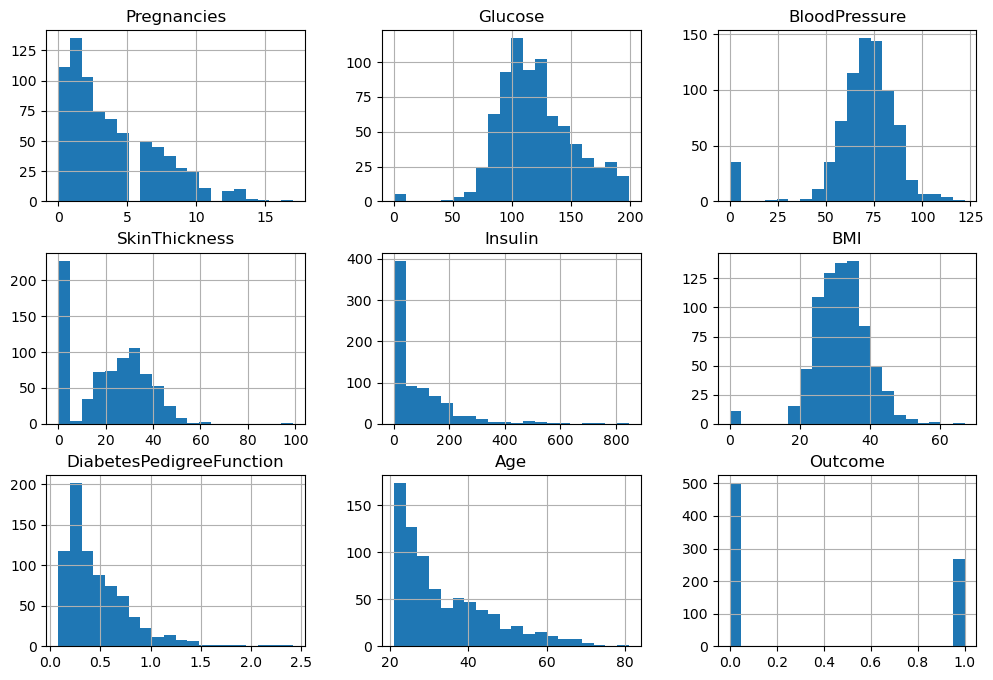

In [7]:
data.hist(figsize=(12, 8), bins=20)
plt.show()

## Fix missing values

Check null values

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Convert zeros into null values

In [9]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0 , np.nan) 
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Replace null values with median

In [10]:
columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for column in columns:
    temp = data.groupby('Outcome')[column].median()
    data.loc[(data['Outcome'] == 0) & (data[column].isna()) , column ] = temp[0]
    data.loc[(data['Outcome'] == 1) & (data[column].isna()) , column ] = temp[1]

## Fix outliers

Check for outliers

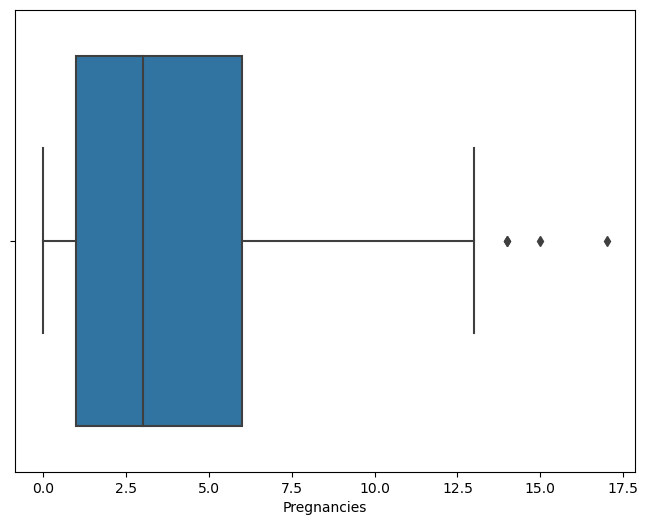

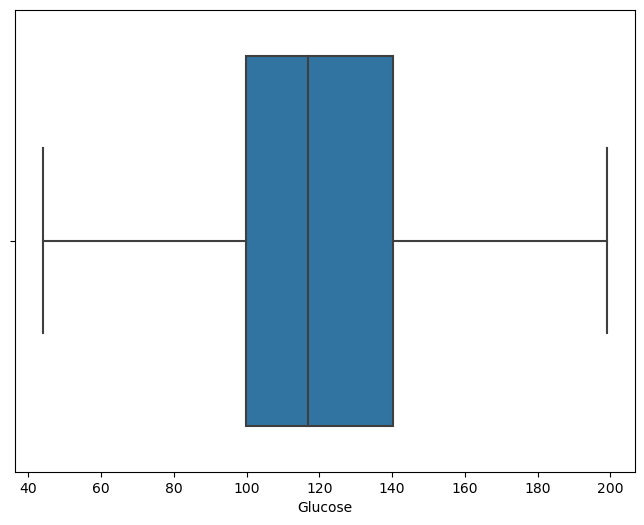

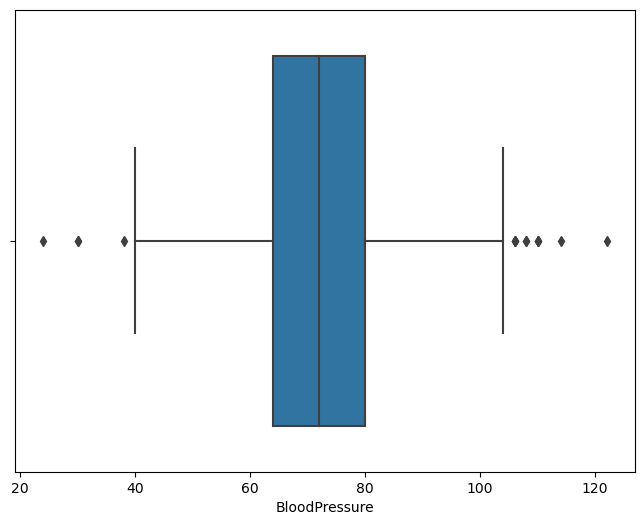

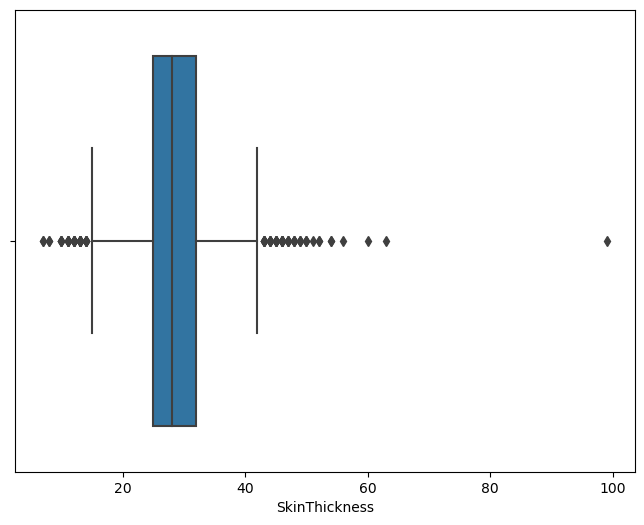

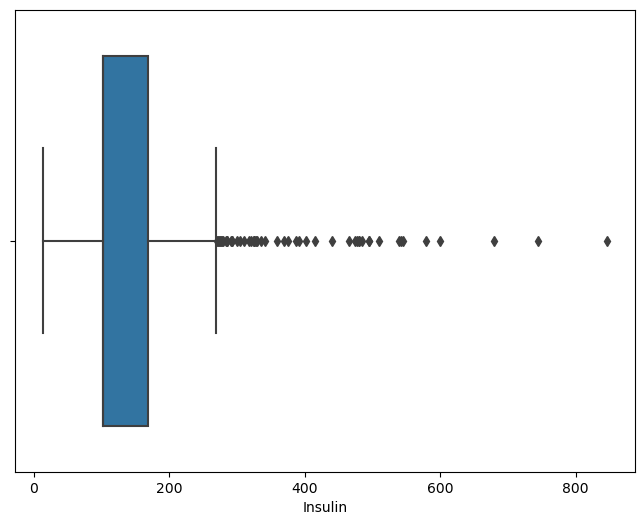

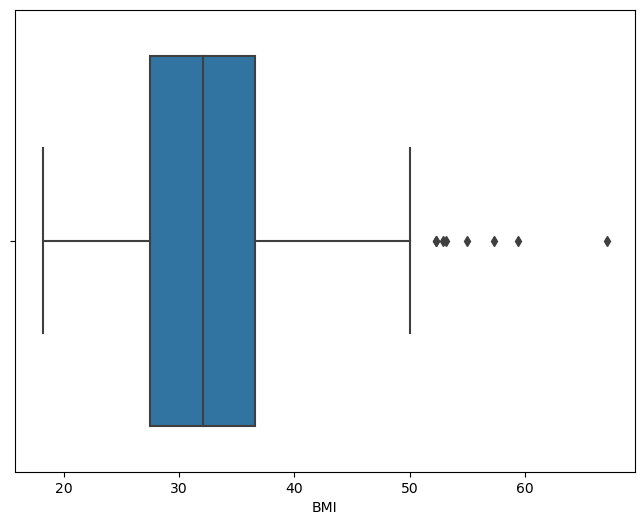

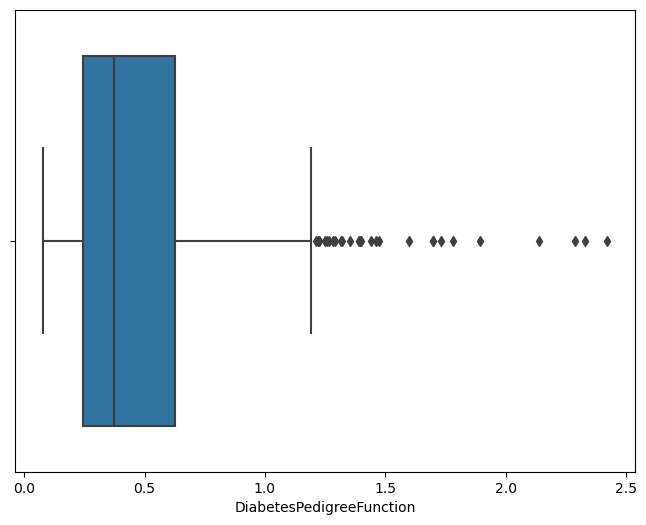

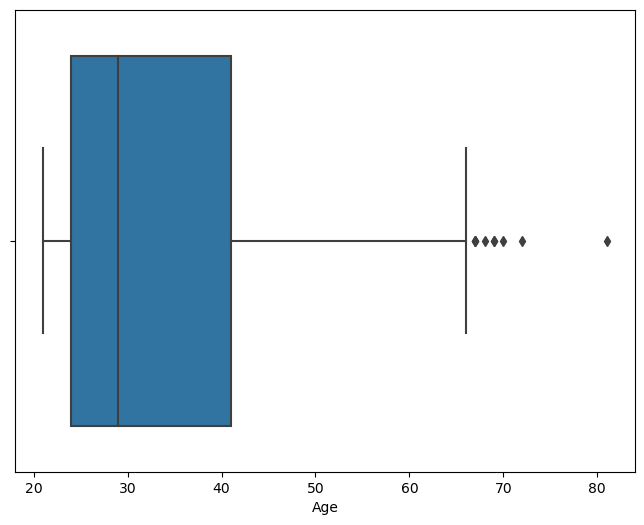

In [11]:
import seaborn as sns
columns = data.columns
columns = columns[:-1]
for column in columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
plt.show()

Remove outliers

In [12]:
numerical_columns = data.columns.to_list()[:-1]

for col in numerical_columns:
    Q1 = data[col].quantile(0.25)  # First quartile (25%)
    Q3 = data[col].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

## Visualize after outliers removal

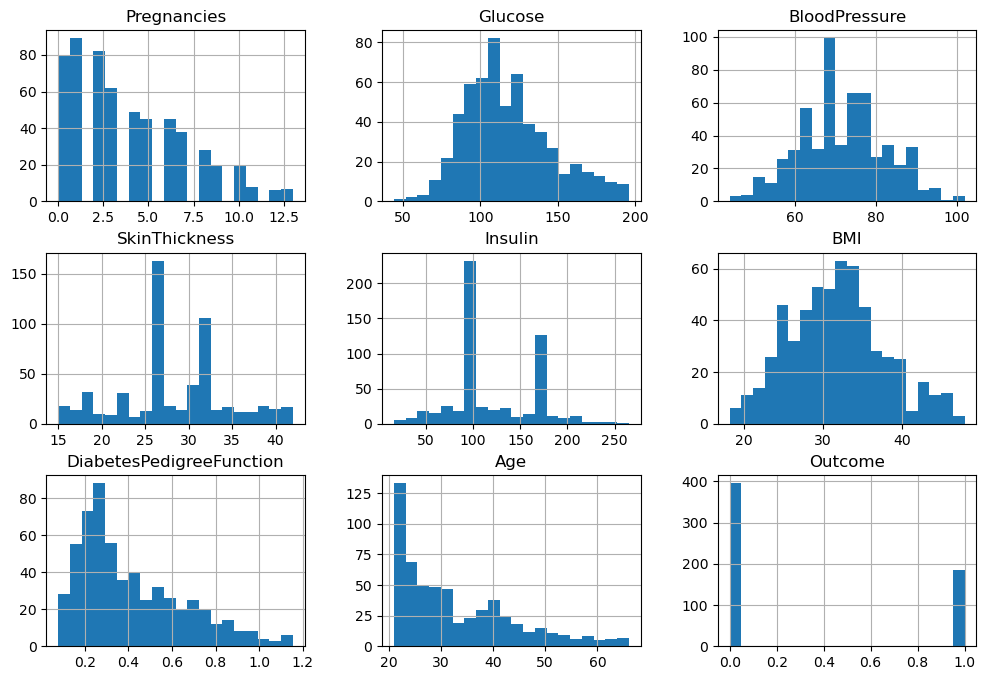

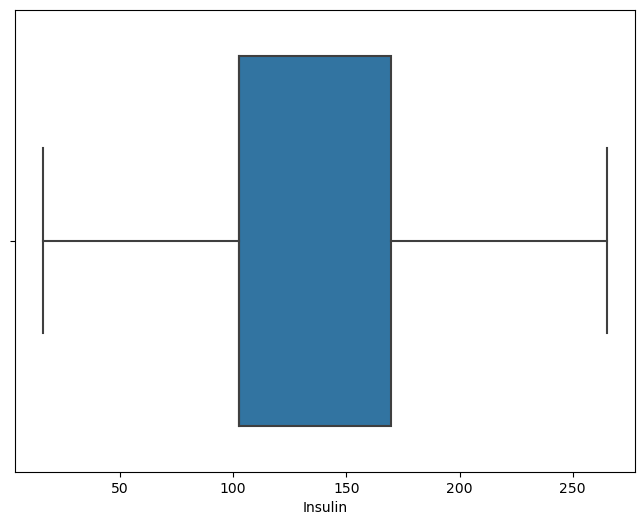

In [13]:
data.hist(figsize=(12, 8), bins=20)
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Insulin'])
plt.show()


# XGB

Split data

In [14]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 44)

Convert dataset into DMatrix

In [15]:
xgb_train = xgb.DMatrix(X_train, label = y_train)
xgb_test = xgb.DMatrix(X_test, label = y_test)

Train model

In [16]:
model_xgb = XGBClassifier(learning_rate=0.6, random_state=42)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Evaluate

In [17]:
y_predict_xgb = model_xgb.predict(X_test)

accuracy=accuracy_score( y_test, y_predict_xgb)
recall = recall_score(y_test, y_predict_xgb)
precision = precision_score(y_test, y_predict_xgb)
mse= mean_squared_error( y_test, y_predict_xgb)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1: {f1_score(y_test, y_predict_xgb)}")
print(f"Mean squared error: {mse}")
print(f"Confusion_Matrix: \n {confusion_matrix(y_test, y_predict_xgb)}")

Accuracy: 0.9310344827586207
Recall: 0.8604651162790697
Precision: 0.9024390243902439
F1: 0.8809523809523809
Mean squared error: 0.06896551724137931
Confusion_Matrix: 
 [[98  4]
 [ 6 37]]


In [18]:
import joblib

# Save the trained model
joblib.dump(model_xgb, 'diabetes_model.pkl')

['diabetes_model.pkl']

In [19]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import streamlit as st
import joblib
import numpy as np

# Load the trained model
model = joblib.load("diabetes_model.pkl")

# Streamlit UI
st.title("Diabetes Prediction App")
st.write("Enter patient details below to predict diabetes.")

# Input fields
pregnancies = st.number_input("Pregnancies", min_value=0, max_value=20, value=1)
glucose = st.number_input("Glucose Level", min_value=0, max_value=200, value=100)
blood_pressure = st.number_input("Blood Pressure", min_value=0, max_value=150, value=70)
skin_thickness = st.number_input("Skin Thickness", min_value=0, max_value=100, value=20)
insulin = st.number_input("Insulin Level", min_value=0, max_value=500, value=80)
bmi = st.number_input("BMI", min_value=0.0, max_value=50.0, value=25.0)
dpf = st.number_input("Diabetes Pedigree Function", min_value=0.0, max_value=3.0, value=0.5)
age = st.number_input("Age", min_value=0, max_value=120, value=30)

# Predict button
if st.button("Predict"):
    input_data = np.array([pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age]).reshape(1, -1)
    prediction = model.predict(input_data)[0]
    
    if prediction == 1:
        st.error("The model predicts **Diabetes** (Positive Case).")
    else:
        st.success("The model predicts **No Diabetes** (Negative Case).")

2025-02-14 20:34:26.982 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.591 
  command:

    streamlit run c:\Users\RANA\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-14 20:34:27.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-14 20:34:27.596 Thread 'MainThread': mis